<a href="https://colab.research.google.com/github/Papadopoulos18/GAN-with-pytorch/blob/main/GAN_on_pytorch_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os


In [2]:
# looks weird, but makes pixel values between -1 and +1
# assume they are transformed from (0,1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])


train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform=transforms.ToTensor(),
    download=True
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [5]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid

)

# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()                                           #maps the output values to be (-1, +1)
)


In [6]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
D = D.to(device)
G = G.to(device)

print(f'Discriminator model: {D} \n and Generator model: {G}')

Discriminator model: Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
) 
 and Generator model: Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=784, bias=True)
  (10): Tanh()
)


In [7]:
# loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
# function to scale img from (-1,+1) back to (0,1)
def scale_image(img):
  out = (img + 1) / 2
  return out

  # create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [9]:
# training loop

# labels to use in the loop (those are our targets) they are contstant values -> so they are not inside the loop
ones_ = torch.ones(batch_size,1).to(device)                                     #torch.Size([128, 1])
zeros_ = torch.zeros(batch_size,1).to(device)

# print(ones_.shape)
# save losses
d_losses = []
g_losses = []

for epoch in range(80):
  for inputs, _ in data_loader:                                                 # input.shape(128,28,28)
    # don't need targets
    
    # reshape and move to GPU
    n = inputs.size(0)                                                          #torch.Size([128, 1, 28, 28])
    inputs = inputs.reshape(n, 784).to(device)                                  #because the last iter will be 96 and not 128 ! so thew actual batch size will not be equal to the specified batch size:torch.Size([128, 784]) and torch.Size([96, 784]) 
    
    # set ones and zeros to correct size
    ones = ones_[:n]                                                            #torch.Size([128, 1]) and torch.Size([96, 1]) for the last one
    zeros = zeros_[:n]
    

    ##########################################
    ########## Train Discriminator ###########
    ##########################################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ##########################################
    ############ Train Generator #############
    ##########################################

    # do it twice (has to be more powerful network than Discriminator)
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # REVERSE the labels!
      g_loss = criterion(fake_outputs, ones)                                    #we pass them as real while they are fake
      
      # greadient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  ## print and save things ##
  print(f'Epoch {epoch}, discr_loss: {d_loss.item()} gener_loss: {g_loss.item()}')

  # Pytorch has a function to save a batch of images to file 
  fake_images = fake_images.reshape(-1, 1, 28, 28)                              #we have to save the image to the correct size
  save_image(scale_image(fake_images), f"gan_images/{epoch + 1}.png")


Epoch 0, discr_loss: 0.6956933736801147 gener_loss: 0.6971151232719421
Epoch 1, discr_loss: 0.6952406764030457 gener_loss: 0.6972999572753906
Epoch 2, discr_loss: 0.6948044300079346 gener_loss: 0.6874464750289917
Epoch 3, discr_loss: 0.6932685375213623 gener_loss: 0.676455020904541
Epoch 4, discr_loss: 0.6930233836174011 gener_loss: 0.6920751333236694
Epoch 5, discr_loss: 0.6864923238754272 gener_loss: 1.1080355644226074
Epoch 6, discr_loss: 0.6458035707473755 gener_loss: 1.6715023517608643
Epoch 7, discr_loss: 0.381869375705719 gener_loss: 2.482830047607422
Epoch 8, discr_loss: 0.2270078957080841 gener_loss: 2.093379497528076
Epoch 9, discr_loss: 0.33730071783065796 gener_loss: 3.3898162841796875
Epoch 10, discr_loss: 0.2126820683479309 gener_loss: 4.25222110748291
Epoch 11, discr_loss: 0.2034430354833603 gener_loss: 3.492323398590088
Epoch 12, discr_loss: 0.1848454624414444 gener_loss: 3.7956275939941406
Epoch 13, discr_loss: 0.27022334933280945 gener_loss: 5.109706878662109
Epoch 14

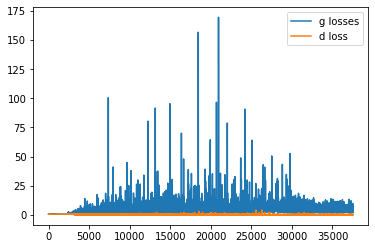

In [10]:
plt.plot(g_losses, label= 'g losses')
plt.plot(d_losses, label= 'd loss')
plt.legend()
plt.show()


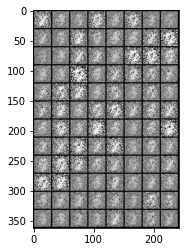

In [12]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)


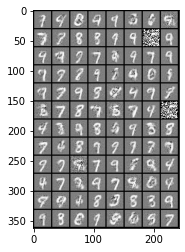

In [13]:

from skimage.io import imread
a = imread('gan_images/40.png')
plt.imshow(a)



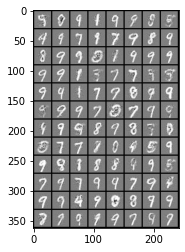

In [14]:
from skimage.io import imread
a = imread('gan_images/80.png')
plt.imshow(a)